In [1]:
# ==========================
# IMPORTS (Core)
# ==========================
import numpy as np
from scipy.signal import windows
from scipy.ndimage import uniform_filter
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from PIL import Image
import random

# ==========================
# RADAR PARAMS (Same as Part 1)
# ==========================
c = 3e8
fc = 60e9
bw = 2e9
T_chirp = 1e-3
fs = 2.5e6
N = int(T_chirp * fs)
slope = bw / T_chirp
t = np.arange(N) / fs

# ==========================
# SIMULATE SCENE (Copied from Part 1)
# ==========================
def simulate_scene(targets, clutter_level=0.2, snr_db=20):
    rx = np.zeros(N, dtype=complex)
    for tg in targets:
        R = tg['range']
        v = tg['velocity']
        rcs = tg['rcs']

        tau = 2*R/c
        phase_delay = np.exp(-1j * 2 * np.pi * slope * tau * t)
        doppler = np.exp(1j * 2 * np.pi * (2*v/c)*fc * t)
        rx += (rcs/(R+1e-6)) * (phase_delay * doppler)

    # clutter
    for _ in range(int(100*clutter_level)):
        R = np.random.uniform(0.5, 8.0)
        v = np.random.uniform(-1.5, 1.5)
        rcs = np.random.uniform(0.01, 0.1)
        tau = 2*R/c
        rx += (rcs/(R+1e-6)) * np.exp(-1j * 2*np.pi * slope * tau * t)

    # noise
    signal_power = np.mean(np.abs(rx)**2)
    snr_linear = 10**(snr_db/10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power/2)*(np.random.randn(N)+1j*np.random.randn(N))
    rx += noise

    return rx

# ==========================
# GENERATE RANGE-DOPPLER MAP (Copied from Part 1)
# ==========================
def generate_rd_map(targets, num_chirps=32, clutter=0.3, snr_db=20):
    frame = []
    for _ in range(num_chirps):
        rx = simulate_scene(targets, clutter_level=clutter, snr_db=snr_db)
        frame.append(rx)
    frame = np.array(frame)

    window_r = windows.hann(N)
    range_fft = np.fft.fft(frame * window_r, axis=1, n=4096)
    range_fft = range_fft[:, :2048]

    window_d = windows.hann(num_chirps)
    rd = np.fft.fftshift(np.fft.fft(range_fft * window_d[:, None], axis=0, n=128), axes=0)

    rd_power = np.abs(rd)**2
    rd_db = 10*np.log10(rd_power + 1e-12)

    return rd_db

# ==========================
# CFAR (Copied from Part 1)
# ==========================
def cfar(rd_map, guard=2, train=8, offset=5):
    rows, cols = rd_map.shape
    cfar_map = np.zeros_like(rd_map, dtype=bool)

    for r in range(train+guard, rows-train-guard):
        for c in range(train+guard, cols-train-guard):
            window = rd_map[
                r-(train+guard):r+(train+guard)+1,
                c-(train+guard):c+(train+guard)+1
            ]

            guard_cells = rd_map[
                r-guard:r+guard+1,
                c-guard:c+guard+1
            ]

            noise = np.sum(window) - np.sum(guard_cells)
            noise /= (window.size - guard_cells.size)

            threshold = noise + offset
            if rd_map[r, c] > threshold:
                cfar_map[r, c] = True

    return cfar_map


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.models import load_model
from scipy.ndimage import label, find_objects
MODEL_DIR = Path.cwd().parent / "models"
cnn = load_model(str(MODEL_DIR/'cnn_model.h5'))
print("Loaded CNN:", cnn)


2025-11-22 14:04:25.414446: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-11-22 14:04:25.414664: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-22 14:04:25.414668: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-22 14:04:25.414703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-22 14:04:25.414713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loaded CNN: <Functional name=functional, built=True>


In [7]:
def max_projection(rd_db):
    return np.max(rd_db, axis=0)

def classify_patch(patch, model=cnn):
    img = max_projection(patch)
    img_norm = (img - img.min())/(img.max()-img.min()+1e-12)
    from PIL import Image
    im = Image.fromarray((img_norm*255).astype('uint8')).convert('RGB').resize((224,224))
    x = np.expand_dims(np.array(im)/255.0, 0)
    p = model.predict(x)[0,0]
    return float(p)


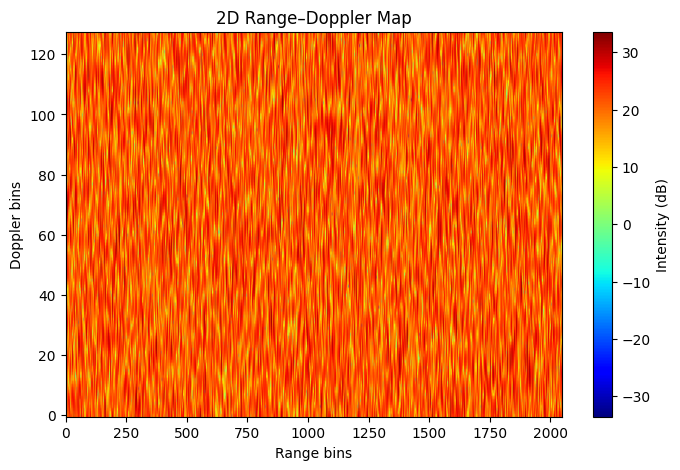

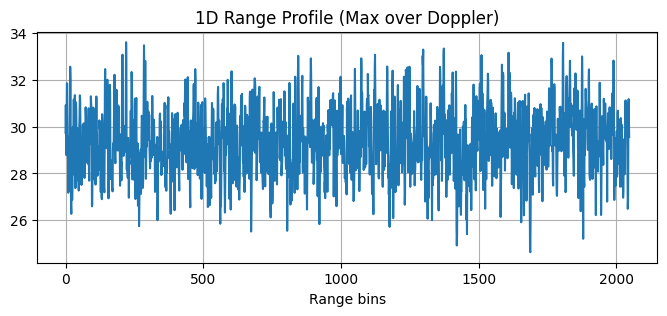

In [8]:
def detect_and_classify(rd_db, min_area=3):
    detections = cfar(rd_db, guard=2, train=8, offset=5)  # copy CFAR from Part1 if not imported
    labeled, n = label(detections.astype(int))
    objs = find_objects(labeled)
    results = []
    for idx, slc in enumerate(objs, start=1):
        if slc is None: continue
        patch = rd_db[slc]
        prob = classify_patch(patch)
        label_name = 'metal' if prob > 0.5 else 'non_metal'
        r0 = (slc[1].start + slc[1].stop)/2
        results.append({'slice': slc, 'prob': prob, 'label': label_name, 'range_bin': r0})
    return results

# Demo: simulate one hidden scene using generate_rd_map from Part1
targets = [{'range':2.8, 'velocity':0.8, 'rcs':1.4}]
rd_db = generate_rd_map(targets, num_chirps=32, clutter=0.6, snr_db=12)

# Show full 2D RD map (correct)
plt.figure(figsize=(8,5))
plt.imshow(rd_db, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label='Intensity (dB)')
plt.title("2D Range–Doppler Map")
plt.xlabel("Range bins")
plt.ylabel("Doppler bins")
plt.show()

# OPTIONAL: Show 1D range profile (correct)
plt.figure(figsize=(8,3))
rp = max_projection(rd_db)
plt.plot(rp)
plt.title("1D Range Profile (Max over Doppler)")
plt.xlabel("Range bins")
plt.grid(True)
plt.show()




In [9]:
res = detect_and_classify(rd_db)
print(res)

2025-11-22 14:09:42.487228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

In [10]:
results = res


Prepared 1051 patches (skipped 1019).
Model input shape: (1051, 224, 224, 3)
Saved 5 detections to /Users/ojasbodke/Desktop/Air G Project/results.json


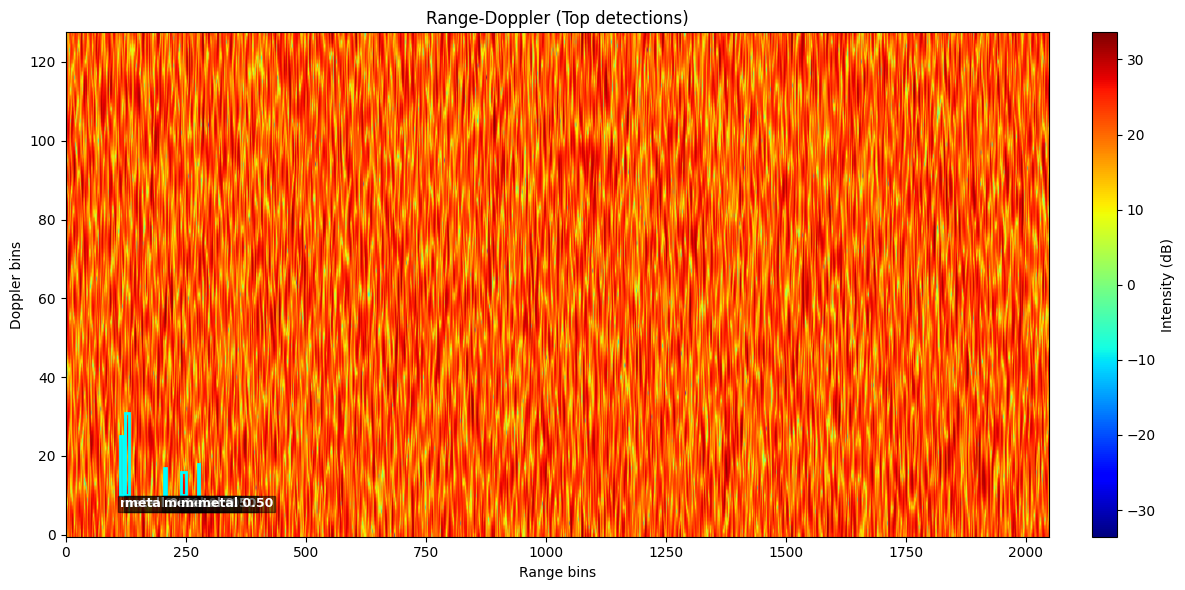

Saved annotated RD map → /Users/ojasbodke/Desktop/Air G Project/output.png


In [11]:
# ===== Revised, robust final detection + visualization cell for Part 3 =====
import json
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.models import load_model

# Parameters (tweakable)
PROB_THRESH = 0.5    # min probability to consider 'metal'
TOP_N = 5            # final number of detections to show
NMS_IOU = 0.25       # IoU threshold for Non-Max Suppression
MIN_PATCH_PIXELS = 16  # skip patches with < this many pixels in area

ROOT = Path.cwd().parent
OUT_PNG = ROOT / "output.png"
OUT_JSON = ROOT / "results.json"
MODEL_DIR = ROOT / "models"

# Accept either 'res' or 'results' (compatibility)
if 'results' in globals():
    detections_raw = results
elif 'res' in globals():
    detections_raw = res
else:
    raise RuntimeError("No detection results found. Run detect_and_classify(rd_db) first.")

# Load model
cnn = load_model(str(MODEL_DIR / 'cnn_model.h5'))

# Helper: parse slice info robustly and return (ds,de,rs,re) or None
def parse_slice(item):
    slc = item.get('slice', None)
    if isinstance(slc, tuple) and len(slc) == 2 and all(isinstance(x, slice) for x in slc):
        ds, de = int(slc[0].start), int(slc[0].stop)
        rs, re = int(slc[1].start), int(slc[1].stop)
        return ds, de, rs, re
    sc = item.get('slice_coords', None)
    if sc and isinstance(sc, (list, tuple)) and len(sc) == 4:
        # handle (dstart, dstop, rstart, rstop) or (d0,d1,r0,r1)
        return int(sc[0]), int(sc[1]), int(sc[2]), int(sc[3])
    # maybe stored as flat list [d0,d1,r0,r1]
    fld = item.get('slice_flat', None)
    if fld and isinstance(fld, (list, tuple)) and len(fld) == 4:
        return int(fld[0]), int(fld[1]), int(fld[2]), int(fld[3])
    return None

# Prepare patches
patch_images = []
meta_boxes = []   # (ds,de,rs,re)
skipped = 0

for item in detections_raw:
    parsed = parse_slice(item)
    if parsed is None:
        skipped += 1
        continue
    ds,de,rs,re = parsed
    if de<=ds or re<=rs:
        skipped += 1
        continue
    # small area check
    if (de-ds)*(re-rs) < MIN_PATCH_PIXELS:
        skipped += 1
        continue
    # Clip to rd_db bounds (safety)
    ds = max(0, min(ds, rd_db.shape[0]-1))
    de = max(ds+1, min(de, rd_db.shape[0]))
    rs = max(0, min(rs, rd_db.shape[1]-1))
    re = max(rs+1, min(re, rd_db.shape[1]))

    patch = rd_db[ds:de, rs:re]  # doppler x range
    if patch.size == 0:
        skipped += 1
        continue

    # Create a visually meaningful 2D input:
    # collapse patch by max over doppler to produce range-profile,
    # tile vertically to give structure, then convert to RGB and resize
    proj = np.max(patch, axis=0)
    norm = (proj - proj.min()) / (proj.max() - proj.min() + 1e-12)
    # create a small 2D image by tiling the 1D profile vertically
    rows = 64
    img2d = np.tile((norm*255).astype('uint8')[np.newaxis,:], (rows,1))
    im = Image.fromarray(img2d).resize((224,224)).convert('RGB')  # ensure RGB
    arr = np.asarray(im, dtype=np.float32) / 255.0
    # defensive channel check
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    if arr.shape[-1] != 3:
        arr = arr[..., :3]

    patch_images.append(arr)
    meta_boxes.append((ds,de,rs,re))

print(f"Prepared {len(patch_images)} patches (skipped {skipped}).")

if len(patch_images) == 0:
    print("No valid patches to predict. Consider lowering CFAR sensitivity or simulating stronger targets.")
else:
    X = np.stack(patch_images, axis=0)
    print("Model input shape:", X.shape)  # sanity check
    preds = cnn.predict(X, verbose=0).ravel().tolist()

    # Build candidate list (boxes in xy format for NMS: x1,y1,x2,y2)
    candidates = []
    for (ds,de,rs,re), p in zip(meta_boxes, preds):
        # Only keep above a minimum raw threshold to reduce clutter
        if p < PROB_THRESH:
            continue
        x1, y1 = int(rs), int(ds)
        x2, y2 = int(re), int(de)
        candidates.append({'box':(x1,y1,x2,y2), 'prob':float(p)})

    if len(candidates) == 0:
        print("No candidates above PROB_THRESH. Try lowering PROB_THRESH.")
        # still save empty json
        with open(OUT_JSON, "w") as f:
            json.dump([], f, indent=2)
    else:
        # Simple NMS implementation
        def iou(boxA, boxB):
            xA = max(boxA[0], boxB[0])
            yA = max(boxA[1], boxB[1])
            xB = min(boxA[2], boxB[2])
            yB = min(boxA[3], boxB[3])
            interW = max(0, xB - xA)
            interH = max(0, yB - yA)
            interArea = interW * interH
            areaA = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
            areaB = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
            union = areaA + areaB - interArea
            return 0.0 if union==0 else interArea/union

        # Sort by prob descending
        candidates = sorted(candidates, key=lambda x: x['prob'], reverse=True)
        keep = []
        for cand in candidates:
            box = cand['box']
            suppress = False
            for k in keep:
                if iou(box, k['box']) > NMS_IOU:
                    suppress = True
                    break
            if not suppress:
                keep.append(cand)
            if len(keep) >= TOP_N:
                break

        # Build final serializable results
        final_results = []
        for item in keep:
            x1,y1,x2,y2 = item['box']
            final_results.append({
                'label': 'metal' if item['prob']>PROB_THRESH else 'non_metal',
                'prob': float(item['prob']),
                'range_start': int(x1),
                'doppler_start': int(y1),
                'range_stop': int(x2),
                'doppler_stop': int(y2)
            })

        # Save JSON
        with open(OUT_JSON, "w") as f:
            json.dump(final_results, f, indent=2)
        print(f"Saved {len(final_results)} detections to {OUT_JSON}")

        # Visualization: draw RD map with final boxes
        fig, ax = plt.subplots(figsize=(12,6))
        m = ax.imshow(rd_db, aspect='auto', origin='lower', cmap='jet')
        cbar = plt.colorbar(m, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Intensity (dB)')

        ax.set_title("Range-Doppler (Top detections)")
        ax.set_xlabel("Range bins")
        ax.set_ylabel("Doppler bins")

        for det in final_results:
            rs, ds, re, de = det['range_start'], det['doppler_start'], det['range_stop'], det['doppler_stop']
            width = re - rs
            height = de - ds
            color = 'cyan' if det['label']=='metal' else 'white'
            rect = Rectangle((rs, ds), width, height, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            # place label above the box if room else inside top-left of the box
            text_y = ds - 3 if ds > 6 else ds + 3
            ax.text(rs, text_y, f"{det['label']} {det['prob']:.2f}",
                    fontsize=9, color='white', weight='bold',
                    bbox=dict(facecolor='black', alpha=0.5, pad=1))

        plt.tight_layout()
        plt.savefig(OUT_PNG, dpi=200)
        plt.show()
        print(f"Saved annotated RD map → {OUT_PNG}")
